In [1]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})

In [2]:
PATH = "../dados/brutos/casos_covid19_7maio2020.csv"

In [3]:
corona_df = pd.read_csv(PATH)
corona_df["date"] = pd.to_datetime(corona_df["date"])
brasil_df = corona_df[corona_df["state"] == "TOTAL"]

In [4]:
data_df = brasil_df[["date", "totalCases"]]
data_df.columns = ["data", "casos"]

In [5]:
data_df.tail()

,data,casos
152404,2020-06-03,589048
158016,2020-06-04,619277
162916,2020-06-05,650117
166942,2020-06-06,676533
174492,2020-06-07,693304


In [6]:
data_df.to_csv("../dados/processados/serie_covid_brasil.csv")
data_df.drop("data", axis=1, inplace=True)

# Casos acumulados

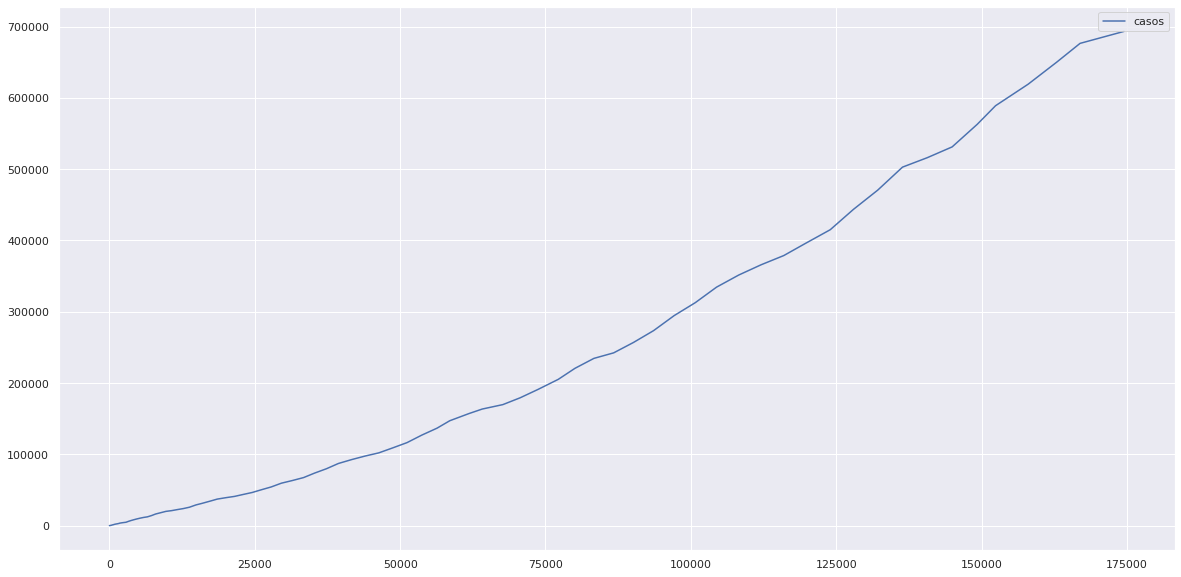

In [7]:
data_df.plot()

# Casos cumulados em escala logarítimica

In [8]:
# Limitando para iniciar no dia do primeiro caso, necessário para que o log esteja definido
# data_df = data_df[data_df["casos"] >= 1]

In [9]:
data_df["log_casos"] = np.log10(data_df["casos"])
data_df.replace([-np.inf], 0, inplace=True)
data_df["index"] = [i for i in range(len(data_df))]

In [10]:
data_df

,casos,log_casos,index
1,1,0.000000,0
3,1,0.000000,1
5,1,0.000000,2
7,2,0.301030,3
8,2,0.301030,4
...,...,...,...
152404,589048,5.770151,99
158016,619277,5.791885,100
162916,650117,5.812992,101
166942,676533,5.830289,102


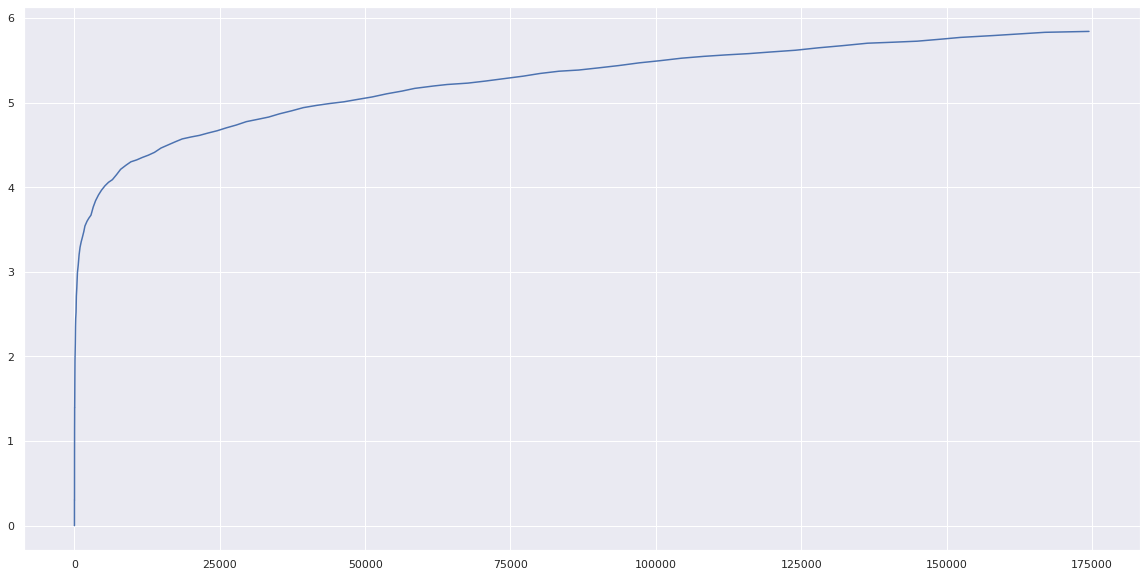

In [11]:
data_df["log_casos"].plot()

# Predições utilizando regressão linear

In [12]:
prediction_window = 10 # dias

In [13]:
x = data_df["index"].values.reshape(-1, 1)
y = data_df["log_casos"].values

In [14]:
regressor = LinearRegression()

In [15]:
preds = cross_val_predict(regressor, x, y, cv=10)
data_df["preds"] = preds

In [16]:
data_df.tail(15)

,casos,log_casos,index,preds
112089,365928,5.563396,89,6.038014
115984,378840,5.578456,90,6.092401
119550,395167,5.596781,91,6.146788
123977,415112,5.618165,92,6.201175
127975,443703,5.647092,93,6.255562
132134,470593,5.672645,94,6.495050
136405,502914,5.701494,95,6.552594
140659,516137,5.712765,96,6.610138
144940,531286,5.725328,97,6.667681
149255,562963,5.750480,98,6.725225


In [17]:
print("r2 score: {}, mse: {}".format(r2_score(y, preds), mean_squared_error(y, preds)))

r2 score: 0.7650590488927291, mse: 0.667343869312102


In [18]:
 _ = regressor.fit(x, y)

In [19]:
regressor.coef_, regressor.intercept_

(array([0.05252985]), 1.248670605912837)

In [24]:
last_day = corona_df["date"].iloc[-1]
last_index = data_df["index"].iloc[-1] + 1

In [25]:
new_dates = [last_day + pd.DateOffset(days=i) for i in range(1, prediction_window+1)]
predictions_df = pd.DataFrame(index=new_dates)
predictions_df["indexes"] = [last_index + i for i in range(prediction_window)]
predictions_df["log_predictions"] = regressor.predict(predictions_df["indexes"].values.reshape(-1, 1))

In [26]:
predictions_df["predictions"] = 10 ** predictions_df["log_predictions"]
predictions_df["predictions"] = predictions_df["predictions"].astype(int)


In [27]:
predictions_df

,indexes,log_predictions,predictions
2020-06-08,104,6.711775,5149617
2020-06-09,105,6.764305,5811722
2020-06-10,106,6.816835,6558955
2020-06-11,107,6.869365,7402263
2020-06-12,108,6.921894,8353998
2020-06-13,109,6.974424,9428101
2020-06-14,110,7.026954,10640305
2020-06-15,111,7.079484,12008366
2020-06-16,112,7.132014,13552324
2020-06-17,113,7.184544,15294794
